# Term Deposit Prediction: Random Forest

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    fbeta_score,
    make_scorer,
    recall_score,
)
from sklearn.model_selection import cross_val_score, train_test_split


### Import data

In [2]:
df_train = pd.read_csv("./train.csv", sep=";")
df_test = pd.read_csv("./test.csv", sep=";")
df_train.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Check data Types

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
df_train.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Convert object data type to category

In [5]:
cols_to_category = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "poutcome",
]
df_train[cols_to_category] = df_train[cols_to_category].astype("category")

### Recode the target variable

In [6]:
df_train["y"] = np.where(df_train["y"] == "no", 0, 1)
df_test["y"] = np.where(df_test["y"] == "no", 0, 1)


### Model

In [7]:
rf_seed = 45
np.random.seed(rf_seed)

train_x = df_train.iloc[:, :-1]
train_y = df_train[["y"]]
train_y = np.ravel(train_y)

train_x.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown


### Encoding

In [8]:
categorical_columns = list(train_x.select_dtypes(include="category").columns.values)
categorical_columns.remove("education")
train_x = pd.get_dummies(
    train_x, prefix=categorical_columns, columns=categorical_columns, drop_first=True
)
recode_education_var = {"unknown": 0, "primary": 1, "secondary": 2, "tertiary": 3}
train_x["education"] = train_x["education"].replace(recode_education_var)
train_x["education"].value_counts(normalize=True)
train_x["education"] = pd.to_numeric(train_x["education"])
train_x.head()


,age,education,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,3,2143,5,261,1,-1,0,False,False,...,False,False,False,True,False,False,False,False,False,True
1,44,2,29,5,151,1,-1,0,False,False,...,False,False,False,True,False,False,False,False,False,True
2,33,2,2,5,76,1,-1,0,False,True,...,False,False,False,True,False,False,False,False,False,True
3,47,0,1506,5,92,1,-1,0,True,False,...,False,False,False,True,False,False,False,False,False,True
4,33,0,1,5,198,1,-1,0,False,False,...,False,False,False,True,False,False,False,False,False,True


In [9]:
test_x = df_test.iloc[:, :-1]
test_y = df_test[["y"]]
test_y = np.ravel(test_y)

test_x = pd.get_dummies(
    test_x, prefix=categorical_columns, columns=categorical_columns, drop_first=True
)
test_x["education"] = test_x["education"].replace(recode_education_var)
test_x.head()


,age,education,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,30,1,1787,19,79,1,-1,0,False,False,...,False,False,False,False,False,True,False,False,False,True
1,33,2,4789,11,220,1,339,4,False,False,...,False,False,False,True,False,False,False,False,False,False
2,35,3,1350,16,185,1,330,1,False,False,...,False,False,False,False,False,False,False,False,False,False
3,30,3,1476,3,199,4,-1,0,False,False,...,False,True,False,False,False,False,False,False,False,True
4,59,2,0,5,226,1,-1,0,True,False,...,False,False,False,True,False,False,False,False,False,True


### Random Forest Model

In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

oversampling = SMOTE(random_state=1)
train_x, train_y = oversampling.fit_resample(train_x, train_y)
SimpleImputer(missing_values=np.nan, strategy="mean").fit_transform(train_x, train_y)


array([[5.800e+01, 3.000e+00, 2.143e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [4.400e+01, 2.000e+00, 2.900e+01, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [3.300e+01, 2.000e+00, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       ...,
       [5.500e+01, 1.000e+00, 1.946e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [4.600e+01, 1.000e+00, 4.410e+02, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [5.300e+01, 2.000e+00, 8.890e+02, ..., 0.000e+00, 0.000e+00,
        1.000e+00]])

In [11]:
train_x

,age,education,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,3,2143,5,261,1,-1,0,False,False,...,False,False,False,True,False,False,False,False,False,True
1,44,2,29,5,151,1,-1,0,False,False,...,False,False,False,True,False,False,False,False,False,True
2,33,2,2,5,76,1,-1,0,False,True,...,False,False,False,True,False,False,False,False,False,True
3,47,0,1506,5,92,1,-1,0,True,False,...,False,False,False,True,False,False,False,False,False,True
4,33,0,1,5,198,1,-1,0,False,False,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79839,35,2,1971,10,386,1,181,1,False,False,...,False,False,False,False,False,False,False,False,False,False
79840,42,2,-485,16,996,1,-1,0,False,False,...,False,False,False,False,False,False,False,False,False,True
79841,55,1,1946,2,224,1,122,4,False,False,...,False,False,False,False,False,False,False,False,False,False
79842,46,1,441,20,154,1,181,1,False,False,...,False,False,False,False,False,False,False,False,True,False


In [12]:
random_forest = RandomForestClassifier(
    n_jobs=-1, random_state=rf_seed, class_weight="balanced_subsample", max_depth=18
)
recall = make_scorer(recall_score)
cross_val = cross_val_score(
    random_forest, train_x, train_y, cv=10, n_jobs=-1, scoring=recall
)
print("Cross validation scores: {}".format(cross_val))
print(
    "%0.2f recall with a standard deviation of %0.2f"
    % (cross_val.mean(), cross_val.std())
)

random_forest.fit(train_x, train_y)
pred = random_forest.predict(train_x)

Cross validation scores: [0.33892786 0.88026052 0.99599299 0.99348861 0.99373747 0.99073146
 0.99273547 0.99574148 0.99348697 0.99373747]
0.92 recall with a standard deviation of 0.20


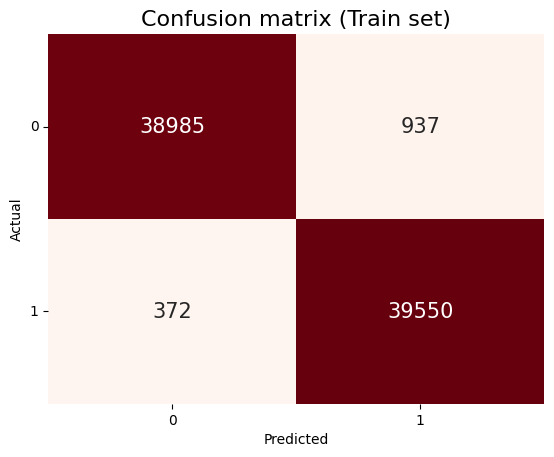

              precision    recall  f1-score   support

           0     0.9905    0.9765    0.9835     39922
           1     0.9769    0.9907    0.9837     39922

    accuracy                         0.9836     79844
   macro avg     0.9837    0.9836    0.9836     79844
weighted avg     0.9837    0.9836    0.9836     79844

The train recall score is 0.9907
The F2 score is 0.99


In [13]:
sns.heatmap(
    confusion_matrix(train_y, pred),
    annot=True,
    fmt="g",
    cbar=False,
    cmap="Reds",
    annot_kws={"size": 15},
)
plt.title("Confusion matrix (Train set)", fontsize=16)
plt.yticks(rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(classification_report(train_y, pred, digits=4))
print("The train recall score is {}".format(np.round(recall_score(train_y, pred), 4)))
print("The F2 score is {}".format(np.round(fbeta_score(train_y, pred, average="binary", beta=2), 2)))


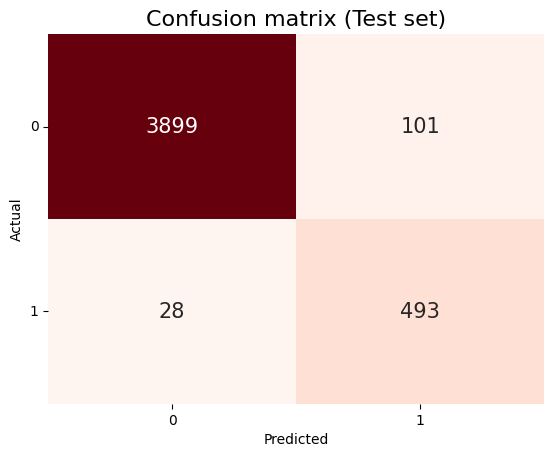

              precision    recall  f1-score   support

           0     0.9929    0.9748    0.9837      4000
           1     0.8300    0.9463    0.8843       521

    accuracy                         0.9715      4521
   macro avg     0.9114    0.9605    0.9340      4521
weighted avg     0.9741    0.9715    0.9723      4521

The test recall score is 0.9463
The F2 score is 0.92


In [14]:
pred = random_forest.predict(test_x)

sns.heatmap(
    confusion_matrix(test_y, pred),
    annot=True,
    fmt="g",
    cmap="Reds",
    cbar=False,
    annot_kws={"size": 15},
)
plt.title("Confusion matrix (Test set)", fontsize=16)
plt.yticks(rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(classification_report(test_y, pred, digits=4))
print("The test recall score is {}".format(np.round(recall_score(test_y, pred), 4)))
print("The F2 score is {}".format(np.round(fbeta_score(test_y, pred, average="binary", beta=2), 2)))

### Random Forest Model 2 (Splitting the training data)

In [15]:
X_train = df_train.iloc[:, :-1]
y = df_train[["y"]]

y_train = np.ravel(y)
X_train.shape, y_train.shape

((45211, 16), (45211,))

### Encoding

In [16]:
categorical_columns = list(X_train.select_dtypes(include="category").columns.values)
categorical_columns.remove("education")
X_train = pd.get_dummies(
    X_train, prefix=categorical_columns, columns=categorical_columns, drop_first=True
)
recode_education_var = {"unknown": 0, "primary": 1, "secondary": 2, "tertiary": 3}
X_train["education"] = X_train["education"].replace(recode_education_var)
X_train["education"].value_counts(normalize=True)
X_train["education"] = pd.to_numeric(X_train["education"])

X_train.head()

,age,education,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,3,2143,5,261,1,-1,0,False,False,...,False,False,False,True,False,False,False,False,False,True
1,44,2,29,5,151,1,-1,0,False,False,...,False,False,False,True,False,False,False,False,False,True
2,33,2,2,5,76,1,-1,0,False,True,...,False,False,False,True,False,False,False,False,False,True
3,47,0,1506,5,92,1,-1,0,True,False,...,False,False,False,True,False,False,False,False,False,True
4,33,0,1,5,198,1,-1,0,False,False,...,False,False,False,True,False,False,False,False,False,True


In [17]:
oversampling = SMOTE(random_state=1)
X_train, y_train = oversampling.fit_resample(X_train, y_train)
SimpleImputer(missing_values=np.nan, strategy="mean").fit_transform(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.10, stratify=y_train, random_state=rf_seed
)

Cross validation scores: [0.94489285 0.94210966 0.94823267 0.94461453 0.9412747  0.94628444
 0.94377957 0.9471194  0.94990259 0.94459911]
0.95 recall with a standard deviation of 0.00


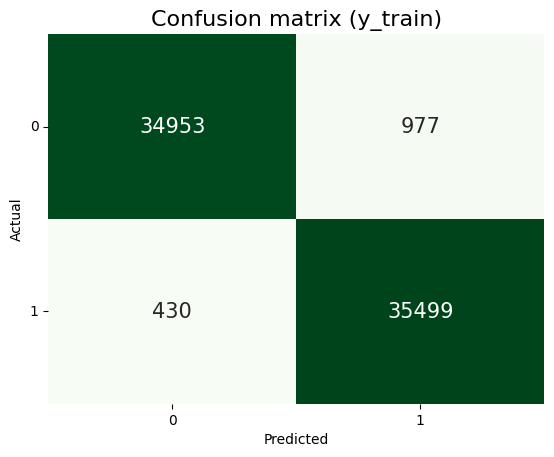

              precision    recall  f1-score   support

           0     0.9878    0.9728    0.9803     35930
           1     0.9732    0.9880    0.9806     35929

    accuracy                         0.9804     71859
   macro avg     0.9805    0.9804    0.9804     71859
weighted avg     0.9805    0.9804    0.9804     71859

The train recall score is 0.99
The F2 score is 0.99


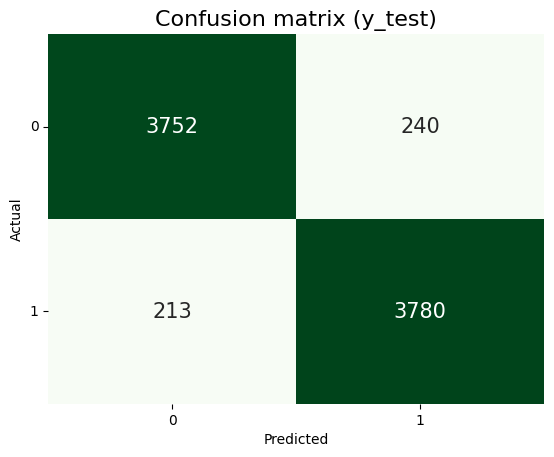

              precision    recall  f1-score   support

           0     0.9463    0.9399    0.9431      3992
           1     0.9403    0.9467    0.9435      3993

    accuracy                         0.9433      7985
   macro avg     0.9433    0.9433    0.9433      7985
weighted avg     0.9433    0.9433    0.9433      7985

The test recall score is 0.95
The F2 score is 0.95


In [18]:
random_forest = RandomForestClassifier(
    n_jobs=-1, random_state=rf_seed, class_weight="balanced_subsample", max_depth=17
)
recall = make_scorer(recall_score)

cross_val = cross_val_score(
    random_forest, X_train, y_train, cv=10, n_jobs=-1, scoring=recall
)
print("Cross validation scores: {}".format(cross_val))
print(
    "%0.2f recall with a standard deviation of %0.2f"
    % (cross_val.mean(), cross_val.std())
)
random_forest.fit(X_train, y_train)

pred = random_forest.predict(X_train)

sns.heatmap(
    confusion_matrix(y_train, pred),
    annot=True,
    fmt="g",
    cbar=False,
    cmap="Greens",
    annot_kws={"size": 15},
)
plt.title("Confusion matrix (y_train)", fontsize=16)
plt.yticks(rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(classification_report(y_train, pred, digits=4))
print("The train recall score is {}".format(np.round(recall_score(y_train, pred), 2)))
print("The F2 score is {}".format(np.round(fbeta_score(y_train, pred, average="binary", beta=2), 2)))


# Get predictions test set
pred = random_forest.predict(X_test)

sns.heatmap(
    confusion_matrix(y_test, pred),
    annot=True,
    fmt="g",
    cmap="Greens",
    cbar=False,
    annot_kws={"size": 15},
)
plt.title("Confusion matrix (y_test)", fontsize=16)
plt.yticks(rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(classification_report(y_test, pred, digits=4))
print("The test recall score is {}".format(np.round(recall_score(y_test, pred), 2)))
print("The F2 score is {}".format(np.round(fbeta_score(y_test, pred, average="binary", beta=2), 2)))


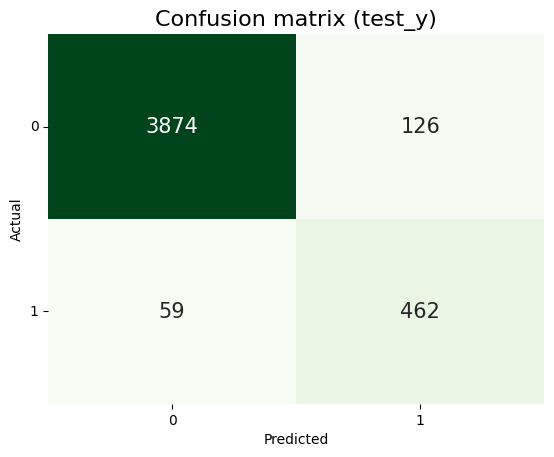

              precision    recall  f1-score   support

           0     0.9850    0.9685    0.9767      4000
           1     0.7857    0.8868    0.8332       521

    accuracy                         0.9591      4521
   macro avg     0.8854    0.9276    0.9049      4521
weighted avg     0.9620    0.9591    0.9601      4521

The test recall score is 0.89
The F2 score is 0.86


In [19]:
pred = random_forest.predict(test_x)

sns.heatmap(
    confusion_matrix(test_y, pred),
    annot=True,
    fmt="g",
    cmap="Greens",
    cbar=False,
    annot_kws={"size": 15},
)
plt.title("Confusion matrix (test_y)", fontsize=16)
plt.yticks(rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(classification_report(test_y, pred, digits=4))
print("The test recall score is {}".format(np.round(recall_score(test_y, pred), 2)))
print("The F2 score is {}".format(np.round(fbeta_score(test_y, pred, average="binary", beta=2), 2)))
